In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

# Define model and create sample trajectory

In [3]:
M  = 2                  # the population has two age groups
N  =  5e4           # and this is the total population

# correct params

beta  = 0.02         # infection rate
gIa   = 1./7            # recovery rate of asymptomatic infectives
gIs   = 1./7            # recovery rate of asymptomatic infectives
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 0.8          # the self-isolation parameter

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])

# set up initial condition
Ia0 = np.array([10, 10])  # each age group has asymptomatic infectives
Is0 = np.array([10, 10])   # and also symptomatic infectives
R0  = np.array([0, 0])  # there are no recovered individuals initially
S0  = Ni - (Ia0 + Is0 + R0)

Tf = 100
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SIR(parameters, M, Ni)
data = sto_model.simulate(S0, Ia0, Is0, contactMatrix, Tf, Nf)
data_array = data['X']
np.save('sto_traj.npy', data_array)

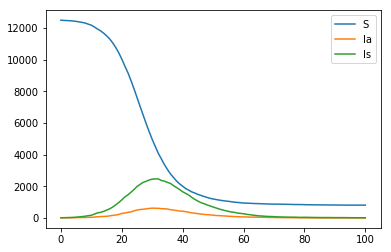

In [4]:
plt.plot(data_array[:, 0], label='S')
plt.plot(data_array[:, M], label='Ia')
plt.plot(data_array[:, 2*M], label='Is')
plt.legend()
plt.show()

# Infer parameters based on part of the trajectory

In [103]:
# load the data and rescale to intensive variables 
Tf_inference = 15 # truncate to only getting the first few datapoints 
Nf_inference = Tf_inference+1

x = np.load('sto_traj.npy').astype('float')
x = (x/N)[:Nf_inference]
steps = 101 # number internal integration steps taken, must be an odd number 


# initialise the estimator 
estimator = pyross.inference.SIR(parameters, M, fi, int(N), steps)

# compute -log_p for the original (correct) parameters 
start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
logp = estimator.obtain_minus_log_p(parameters, x, Tf_inference, Nf_inference, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-289.85385562902246
0.08897614479064941


In [104]:
# take a guess 
beta_g = 0.2
gIa_g = 0.01
gIs_g = 0.01
alpha_g = 0.1
guess = [alpha_g, beta_g, gIa_g, gIs_g]

# compute -log_p for the initial guess 
parameters = {'alpha':alpha_g, 'beta':beta_g, 'gIa':gIa_g, 'gIs':gIs_g,'fsa':fsa}
logp = estimator.obtain_minus_log_p(parameters, x, Tf_inference, Nf_inference, contactMatrix)
print(logp) 

5404.991885565203


In [105]:
# inference 

eps = 1e-4 
bounds = [(eps, 0.8), (eps, 0.2), (eps, 0.6), (eps, 0.6)] # give some bounds
start_time = time.time() 
params, nit = estimator.inference(guess, x, Tf_inference, Nf_inference, contactMatrix, 
                                  niter=1, method='L-BFGS-B', bounds=bounds, 
                                  eps=eps, verbose=False)
# sometimes produce errors if input is bad, ignore and let basinhopping do its magic
end_time = time.time()
print(params) # best guess 
print(nit) # number of iterations of the optimization run 
print(end_time - start_time)

[0.1986919  0.02032194 0.16259239 0.13732432]
1
26.228431940078735


In [106]:
# compute log_p for best estimate 
start_time = time.time() 
parameters = {'alpha': params[0], 'beta': params[1], 'gIa': params[2], 'gIs': params[3],'fsa':fsa}
logp = estimator.obtain_minus_log_p(parameters, x, Tf_inference, Nf_inference, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-291.00392979851154
0.1888439655303955


In [108]:
hessian = estimator.hessian(params,x,Tf_inference,Nf_inference,contactMatrix)
cov = np.linalg.inv(hessian)
#cov

array([[ 9.97280861e-04, -5.33044129e-07,  1.57244821e-03,
        -4.12025529e-04],
       [-5.33044129e-07,  2.37531627e-07, -8.81738646e-07,
         2.44864575e-07],
       [ 1.57244821e-03, -8.81738646e-07,  2.82499636e-03,
        -7.04582377e-04],
       [-4.12025529e-04,  2.44864575e-07, -7.04582377e-04,
         2.13953016e-04]])

# Compare forecast based on inferred parameters to full trajectory

In [109]:
parameters = {'alpha': params[0], 'beta': params[1], 'gIa': params[2], 'gIs': params[3],'fsa':fsa,
             'cov':cov}

# Initialise pyross forecast module
model_forecast = pyross.forecast.SIR(parameters, M, Ni)

In [147]:
# Initial condition for forecast is last configuration from inference-trajectory
S0_forecast = x[-1,:2]*N
Ia0_forecast = x[-1,2:4]*N
Is0_forecast = x[-1,4:]*N

# Number of simulations over which we average
Ns = 500 

Tf_forecast = Tf - Tf_inference
Nf_forecast = Tf_forecast+1


result_forecast = model_forecast.simulate(S0_forecast, Ia0_forecast, Is0_forecast, 
                                          contactMatrix, Tf_forecast, Nf_forecast,
                                      verbose=True,
                                     Ns=Ns) 

trajectories_forecast = result_forecast['X']
t_forecast = result_forecast['t'] + Tf_inference

Finished. Time needed for evaluation: 00:00:02


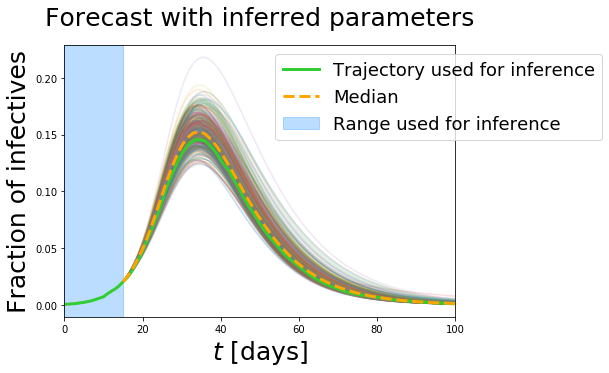

In [150]:
fontsize=25
#

ylabel=r'Fraction of infectives'
#

# Plot total number of symptomatic infectives
cur_trajectories_forecast = trajectories_forecast[:,4] + trajectories_forecast[:,5]
cur_mean_forecast = np.mean( cur_trajectories_forecast, axis=0)
percentile = 10
percentiles_lower = np.percentile(cur_trajectories_forecast,percentile,axis=0)
percentiles_upper = np.percentile(cur_trajectories_forecast,100-percentile,axis=0)
percentiles_median = np.percentile(cur_trajectories_forecast,50,axis=0)


cur_trajectory_underlying = data_array[:,4] + data_array[:,5]

#
# Plot trajectories
#
fig, ax = plt.subplots(1,1,figsize=(7,5))
ax.axvspan(0, Tf_inference, 
           label='Range used for inference',
           alpha=0.3, color='dodgerblue')
ax.set_title(r'Forecast with inferred parameters',
             y=1.05,
            fontsize=fontsize)
for i,e in enumerate(cur_trajectories_forecast):
    ax.plot(t_forecast,e/N,
            alpha=0.15,
           )
'''ax.fill_between(t_arr,traj_mean[plot_index] - traj_std[plot_index],
                traj_mean[plot_index] + traj_std[plot_index],
                alpha=0.7,
                color='limegreen',
                       label='Std deviation')
ax.plot(t_arr,traj_mean[plot_index] - traj_std[plot_index],
                alpha=1,
        label='Std deviation',
        lw=1.5,
        ls='--',
                color='black')
ax.plot(t_arr,traj_mean[plot_index] + traj_std[plot_index],
                alpha=1,
        #label='Std deviation',
        lw=1.5,
        ls='--',
                color='black')
''';
ax.plot(cur_trajectory_underlying/N,
        lw=3,
        color='limegreen',
       label='Trajectory used for inference')

ax.plot(t_forecast,percentiles_median/N,
                alpha=1,ls='--',
        color='orange',label='Median',
       lw=3)
''' # remove comments to plot percentiles
ax.plot(t_forecast,percentiles_lower/N,
                alpha=1,
        lw=2,
        label='Percentiles',
        ls='dotted',
        color='red',
       )
ax.plot(t_forecast,percentiles_upper/N,
                alpha=1,
        lw=2,
        color='red',
        ls='dotted',
       )
''';

ax.set_xlim(0,np.max(t_forecast))
ax.set_ylabel(ylabel,fontsize=fontsize)
ax.set_xlabel(r'$t$ [days]',fontsize=fontsize)
ax.legend(loc='upper right',bbox_to_anchor=(1.4,1),
          fontsize=18)
plt.show(fig)
plt.close(fig)